<a href="https://colab.research.google.com/github/sishinami/usdjpy/blob/main/60%E5%88%86%E8%B6%B3%E3%81%A7%E6%AC%A1%E3%81%AE180%E5%88%86%E3%82%92%E4%BA%88%E6%B8%AC%E3%81%99%E3%82%8BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import pandas as pd

In [43]:
df = pd.read_csv('drive/MyDrive/USDJPY/USDJPYmin.csv'
  ,header=None
  , names=['date','time','start','heikin1','heikin2','end','dekidaka'])

In [50]:
df = df[:100000]

In [51]:
y = np.array(df["end"].tolist())
sc = MinMaxScaler(feature_range=(0, 1))   # 標準化
y = y.reshape(-1, 1)
y = sc.fit_transform(y)

x = np.arange(len(y))

In [52]:
# 60分足で 次の180分後を予測する
input_len = 60

X, Y = [], []
for i, _ in enumerate(x):
    if (i+input_len+180 >= len(x)):
        break
    X.append(y[i:i+input_len])
    Y.append(y[i+input_len+180][0])

In [53]:
EPOCH = 10      # 学習エポック
TRAIN_RATE = 0.8  # 全データ中の学習用データの割合
BATCH_SIZE = 32 
split_index = int(len(X)*TRAIN_RATE)
# 学習・テスト用データに分割
train_x = X[:split_index]
train_y = Y[:split_index]
test_x = X[split_index:]
test_y = Y[split_index:]

train_x = np.array(train_x).reshape(len(train_x), -1, 1)
test_x = np.array(test_x).reshape(len(test_x), -1, 1)
train_y = np.array(train_y).reshape(len(train_y))

モデルをいろいろ試してみる

In [54]:
# モデルの構築と学習
input_shape = (len(train_x[0]), 1)
model = Sequential()
model.add(SimpleRNN(100, return_sequences=False, input_shape=input_shape))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")

In [55]:
model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCH, verbose=1)


Epoch 1/10
1534/2494 [=================>............] - ETA: 20s - loss: 0.0041

KeyboardInterrupt: ignored

In [19]:
score = model.evaluate(test_x, np.array(test_y))


936/936 [==============================] - 5s 5ms/step - loss: 0.0044


In [20]:
# train loss: 学習データに対する損失関数の値
# → この値が小さくなると、学習ができている。
# train accuracy: 学習データに対する分類の正答率
# → 損失関数が小さいということは分類精度が高いということなので、「loss が下がるほど、accuracy が上がる」という関係
# test loss: テストデータに対する損失関数の値
# → この値が小さくなると、汎化性能が出ている。
# test accuracy: テストデータに対する分類の正答率
print(score)
#0.004380103666335344  ほんとかよ？

0.004380103666335344


ＧＰＵで試してみたい
ＧＰＵ無しだと ２７秒かかるのが、さて早くなるのか？


In [9]:
from keras.utils import multi_gpu_model


ImportError: ignored

In [8]:
import keras
print(keras.__version__) 

2.4.3


In [11]:
 from tensorflow.python.client import device_lib
 device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1991224854722916663, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16664884393171193044
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

strategy = tf.distribute.MirroredStrategy()
input_shape = (len(train_x[0]), 1)

with strategy.scope():
  model = tf.keras.Sequential()

  model.add(SimpleRNN(100, return_sequences=False, input_shape=input_shape))
  model.add(Dense(1))
  model.add(Activation("linear"))


  model.compile(loss="mse", optimizer="adam")    
  
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)              

In [17]:
model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCH, verbose=1)


Epoch 1/10
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
2183/2183 [==============================] - 84s 36ms/step - loss: 0.0043
Epoch 2/10
 511/2183 [======>.......................] - ETA: 59s - loss: 9.1043e-04

KeyboardInterrupt: ignored

In [23]:
!nvidia-smi

Tue Apr 13 04:43:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    32W /  70W |    388MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

おっそｗｗｗｗ 別の方法を考える

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


NUM_DIM = 8  # 中間層の次元数

model = Sequential()

# return_sequenceがTrueなので全RNN層が出力を返す(Falseだと最後のRNN層のみが出力を返す)
model.add(LSTM(NUM_DIM, input_shape=input_shape, return_sequences=False))
model.add(Dense(1, activation="linear"))  #全結合層
model.compile(loss="mean_squared_error", optimizer="sgd")
model.summary()



Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 8)                 320       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCH, verbose=1)


Epoch 1/2
214/214 [==============================] - 2s 4ms/step - loss: 0.1108
Epoch 2/2
214/214 [==============================] - 1s 4ms/step - loss: 0.0154


はやい、これなら回せる


In [87]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, SimpleRNN
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import pandas as pd

In [ ]:
save_model_name = 'drive/MyDrive/USDJPY/21-0413-2/'  # 保存しておくモデルの名前
EPOCH = 10      # 学習エポック
TRAIN_RATE = 0.9  # 全データ中の学習用データの割合 - 元データが多いので 0.9を学習に回す
BATCH_SIZE = 32 


In [88]:
df = pd.read_csv('drive/MyDrive/USDJPY/USDJPYmin.csv'
  ,header=None
  , names=['date','time','start','heikin1','heikin2','end','dekidaka'])

In [89]:
# 標準化
y = np.array(df["end"].tolist())
sc = MinMaxScaler(feature_range=(0, 1)) 
y = y.reshape(-1, 1)
y = sc.fit_transform(y)

x = np.arange(len(y))

# 60分足で 次の180分後を予測する
input_len = 60

X, Y = [], []
for i, _ in enumerate(x):
    if (i+input_len+180 >= len(x)):
        break
    X.append(y[i:i+input_len])
    Y.append(y[i+input_len+180][0])

In [90]:
import pickle

with open('drive/MyDrive/USDJPY/MinMaxScaler.pickle', mode='wb') as f: 
    pickle.dump(sc, f)  



In [91]:

split_index = int(len(X)*TRAIN_RATE)
# 学習・テスト用データに分割 未来データを予測したいので 単純に先っぽの方をテストに回す
train_x = X[:split_index]
train_y = Y[:split_index]
test_x = X[split_index:]
test_y = Y[split_index:]

train_x = np.array(train_x).reshape(len(train_x), -1, 1)
test_x = np.array(test_x).reshape(len(test_x), -1, 1)
train_y = np.array(train_y).reshape(len(train_y))

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


NUM_DIM = 12  # 中間層の次元数 12の理由は特にない 適当 決め方誰か教えて

model = Sequential()
input_shape = (len(train_x[0]), 1)

# return_sequenceFalse 最後のRNN層のみが出力を返す
model.add(LSTM(NUM_DIM, input_shape=input_shape, return_sequences=False))
model.add(Dense(1, activation="linear"))  #全結合層 であってる？

model.compile(loss="mean_squared_error", optimizer="sgd")
model.summary()



Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 12)                672       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 13        
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [93]:
model.fit(train_x, train_y, batch_size=BATCH_SIZE, epochs=EPOCH, verbose=1)


Epoch 1/2
127710/127710 [==============================] - 498s 4ms/step - loss: 1.6026e-04
Epoch 2/2
127710/127710 [==============================] - 499s 4ms/step - loss: 2.3944e-05


In [94]:
score = model.evaluate(test_x, np.array(test_y))


54733/54733 [==============================] - 134s 2ms/step - loss: 1.8229e-05


In [95]:
# train loss: 学習データに対する損失関数の値
# → この値が小さくなると、学習ができている。
# train accuracy: 学習データに対する分類の正答率
# → 損失関数が小さいということは分類精度が高いということなので、「loss が下がるほど、accuracy が上がる」という関係
# test loss: テストデータに対する損失関数の値
# → この値が小さくなると、汎化性能が出ている。
# test accuracy: テストデータに対する分類の正答率
print(score)
#1.822907324822154e-05  ほんとかよ？

1.822907324822154e-05


In [96]:
predict_y = model.predict(test_x)   # 予測値の抽出
predict_y = sc.inverse_transform(predict_y)     # 元の値に戻す

In [97]:
model.save(save_model_name)

INFO:tensorflow:Assets written to: drive/MyDrive/USDJPY/21-0413-2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/USDJPY/21-0413-2/assets


ここから下は図にするところです

In [98]:
df['datetime'] = df['date'] + ' ' + df['time']

In [100]:
label_x = df["datetime"].apply(lambda x: datetime.strptime(x, "%Y.%m.%d %H:%M"))

In [102]:
new_format = "%Y-%m-%dT%H:%M"
label_x = label_x.apply(lambda x: x.strftime(new_format)).tolist()
label_x = label_x[len(y)-len(test_y):]

test_y = sc.inverse_transform(np.array(test_y).reshape(-1,1))
test_y = test_y.reshape(len(test_y))

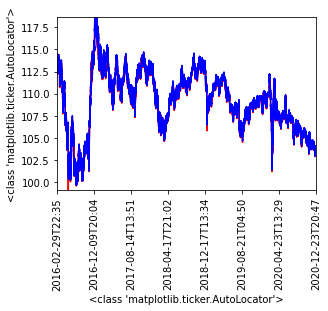

In [103]:
import matplotlib as mpl

fig = plt.figure()
ax = fig.add_axes((0.2, 0.2, 0.6, 0.6))

ax.plot(label_x, test_y, color = "red")
ax.plot(label_x, predict_y, color = "blue")

ax.xaxis.set_major_locator(mpl.ticker.AutoLocator())
ax.yaxis.set_major_locator(mpl.ticker.AutoLocator())

ax.set(xlim=(min(label_x),max(label_x)), ylim=(min(test_y), max(test_y)))
plt.xticks(rotation=90)

ax.set(xlabel=type(ax.xaxis.get_major_locator()),
       ylabel=type(ax.yaxis.get_major_locator()))

plt.show()